# TP - Classification d'images m√©dicales avec CNN et Transfert d‚Äôapprentissage

## √âtape 1 : Pr√©paration de l‚Äôenvironnement

### 1.1 Importer les biblioth√®ques n√©cessaires

In [69]:
# Biblioth√®ques principales pour la manipulation des donn√©es
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

# Biblioth√®ques PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Biblioth√®ques pour l‚Äô√©valuation
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

### 1.2 V√©rification de l‚Äôutilisation du GPU

In [72]:
# V√©rifie si un GPU est disponible sinon utilise le CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Appareil utilis√© :", device)

Appareil utilis√© : cpu


## √âtape 2 : Chargement et visualisation des donn√©es

### 2.1 D√©finir les transformations (Data Augmentation + Normalisation)

In [76]:
# Pour l'entra√Ænement : on applique des augmentations pour am√©liorer la robustesse du mod√®le
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),     # effet miroir al√©atoire
    transforms.RandomRotation(10),         # rotation al√©atoire jusqu‚Äô√† 10¬∞
    transforms.ToTensor(),                 # conversion en tenseur
    transforms.Normalize([0.485, 0.456, 0.406],  # normalisation bas√©e sur ImageNet
                         [0.229, 0.224, 0.225])
])

# Pour le test : on garde juste le redimensionnement et la normalisation
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


### 2.2 Charger les jeux d‚Äôimages avec ImageFolder

In [79]:
# Chemins vers les dossiers d'images
data_dir = "C:/Users/medmo/Data_classification_CNN/data"

# Chargement des datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transforms)

# Cr√©ation des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Affichage des noms de classes
class_names = train_dataset.classes
print("Classes disponibles :", class_names)

Classes disponibles : ['benign', 'malignant']


### 2.3 Affichage de quelques images d‚Äôentra√Ænement

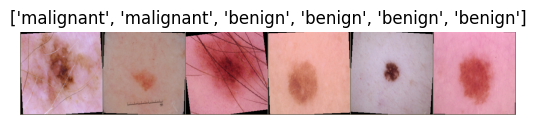

In [82]:
# Fonction pour afficher une image avec d√©s-normalisation
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

# Affichage d'un batch d‚Äôimages
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs[:6])
imshow(out, title=[class_names[i] for i in classes[:6]])

### Question : Pourquoi applique-t-on des transformations diff√©rentes pour les images d'entra√Ænement et celles de test ?

### R√©ponse :
- Les transformations appliqu√©es sur les images d'entra√Ænement (comme la rotation ou le miroir) permettent 
- d‚Äôaugmenter artificiellement la taille et la diversit√© du dataset pour √©viter l‚Äôoverfitting.
- Pour les images de test, on ne veut pas de transformations al√©atoires. On veut seulement normaliser
- les images pour que l‚Äô√©valuation soit coh√©rente et repr√©sentative.

## √âtape 3 : Impl√©mentation d‚Äôun CNN personnalis√© (convolutional neural network)

### Objectif de cette √©tape :
Cr√©er un mod√®le CNN simple en partant de z√©ro, adapt√© √† la classification d‚Äôimages m√©dicales.
Nous allons :
1. D√©finir une architecture personnalis√©e (Conv + ReLU + Pool + FC)
2. Choisir la fonction de perte
3. Configurer l‚Äôoptimiseur

### 3.1 D√©finition du mod√®le CNN personnalis√©

In [88]:
# Mod√®le CNN personnalis√©
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        self.features = nn.Sequential(
            # Couche 1 : Convolution 3x3 -> ReLU -> MaxPool
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Couche 2 : Convolution 3x3 -> ReLU -> MaxPool
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Couche 3 : Convolution 3x3 -> ReLU -> MaxPool
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),  # 224 / 2 / 2 / 2 = 28
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Cr√©ation du mod√®le
num_classes = len(class_names)
model = CustomCNN(num_classes).to(device)
print("Mod√®le cr√©√© avec succ√®s")

Mod√®le cr√©√© avec succ√®s


### 3.2 D√©finir la fonction de perte et l‚Äôoptimiseur

In [91]:
# Fonction de perte (cross-entropy adapt√©e pour la classification multi-classes)
criterion = nn.CrossEntropyLoss()

# Optimiseur (Adam g√©n√©ralement efficace pour ce genre de t√¢che)
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Question : Pourquoi la fonction de perte CrossEntropyLoss est-elle utilis√©e ici ?

### R√©ponse :
- La fonction CrossEntropyLoss est adapt√©e pour les t√¢ches de classification multi-classes.
- Elle combine log_softmax et negative log likelihood en une seule fonction efficace,
- ce qui permet au mod√®le d‚Äôapprendre √† pr√©dire correctement la probabilit√© de chaque classe.

## √âtape 4 : Entra√Ænement du mod√®le avec m√©triques d‚Äô√©valuation adapt√©es

### 4.1 Fonction d'entra√Ænement (train) et d‚Äô√©valuation (validate)

In [96]:
from sklearn.metrics import classification_report, confusion_matrix
import time

# Fonction d'entra√Ænement
def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10):
    model.to(device)
    
    for epoch in range(num_epochs):
        print(f"\n √âpoque {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc="Entra√Ænement", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Perte d'entra√Ænement : {epoch_loss:.4f}")

        # √âvaluation sur validation
        validate_model(model, val_loader, device)

### 4.2 Fonction d‚Äô√©valuation : m√©triques m√©dicales (pr√©cision, rappel, F1‚Ä¶)

In [99]:
def validate_model(model, val_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Rapport de classification
    print("\n Rapport de classification (validation) :")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.title("Matrice de confusion")
    plt.xlabel("Pr√©dit")
    plt.ylabel("Vrai")
    plt.show()

### 4.3 Lancer l'entra√Ænement

In [111]:
# Cr√©ation de val_loader

from torch.utils.data import random_split, DataLoader

# Supposons que 'train_dataset' est d√©j√† d√©fini
# On r√©serve 80% pour l'entra√Ænement, 20% pour la validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)


 √âpoque 1/10


Perte d'entra√Ænement : 0.6449

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.93      0.61      0.74       282
   malignant       0.68      0.94      0.79       246

    accuracy                           0.77       528
   macro avg       0.80      0.78      0.76       528
weighted avg       0.81      0.77      0.76       528



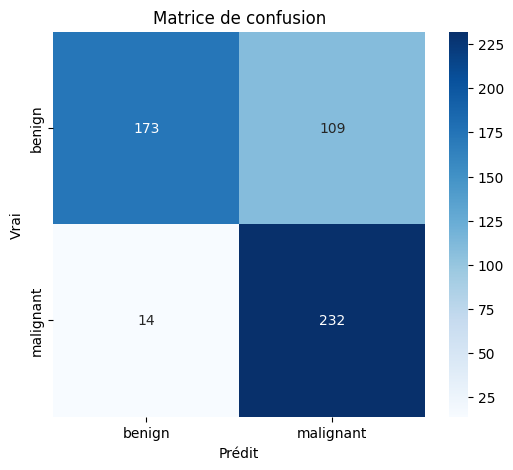


 √âpoque 2/10


Perte d'entra√Ænement : 0.4146

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.88      0.70      0.78       282
   malignant       0.72      0.89      0.80       246

    accuracy                           0.79       528
   macro avg       0.80      0.80      0.79       528
weighted avg       0.81      0.79      0.79       528



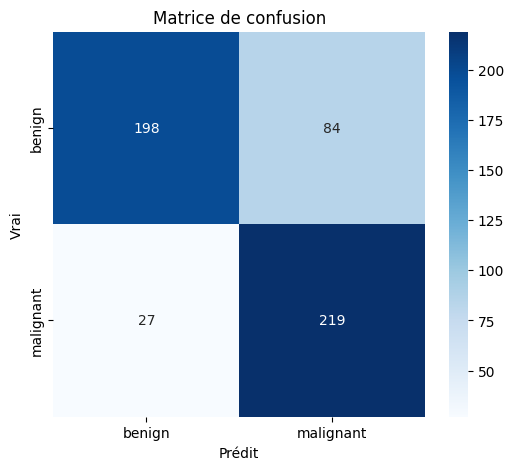


 √âpoque 3/10


Perte d'entra√Ænement : 0.4070

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.91      0.64      0.75       282
   malignant       0.69      0.93      0.79       246

    accuracy                           0.77       528
   macro avg       0.80      0.78      0.77       528
weighted avg       0.81      0.77      0.77       528



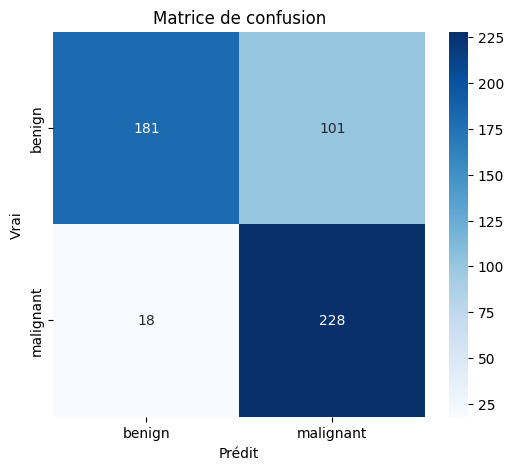


 √âpoque 4/10


Perte d'entra√Ænement : 0.3846

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.93      0.66      0.77       282
   malignant       0.71      0.94      0.81       246

    accuracy                           0.79       528
   macro avg       0.82      0.80      0.79       528
weighted avg       0.83      0.79      0.79       528



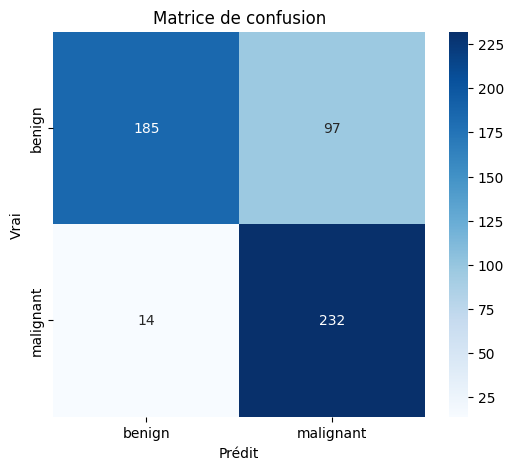


 √âpoque 5/10


Perte d'entra√Ænement : 0.3603

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.91      0.70      0.79       282
   malignant       0.73      0.92      0.81       246

    accuracy                           0.80       528
   macro avg       0.82      0.81      0.80       528
weighted avg       0.82      0.80      0.80       528



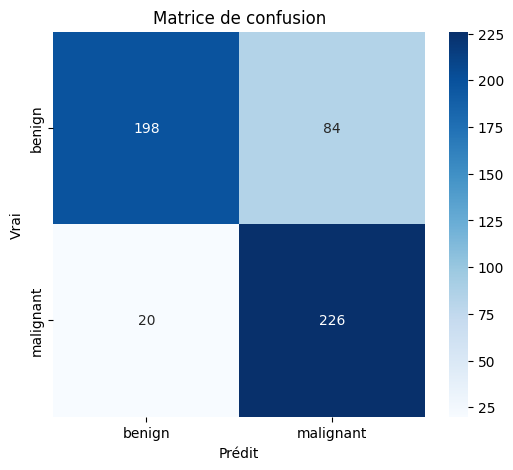


 √âpoque 6/10


Perte d'entra√Ænement : 0.3586

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.85      0.80      0.82       282
   malignant       0.78      0.84      0.81       246

    accuracy                           0.82       528
   macro avg       0.82      0.82      0.82       528
weighted avg       0.82      0.82      0.82       528



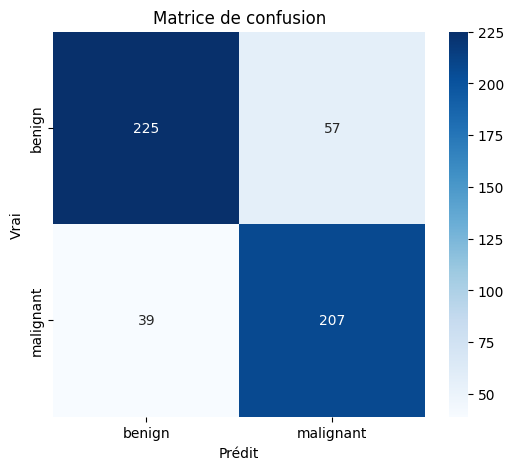


 √âpoque 7/10


Perte d'entra√Ænement : 0.3521

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.88      0.77      0.82       282
   malignant       0.77      0.88      0.82       246

    accuracy                           0.82       528
   macro avg       0.82      0.82      0.82       528
weighted avg       0.83      0.82      0.82       528



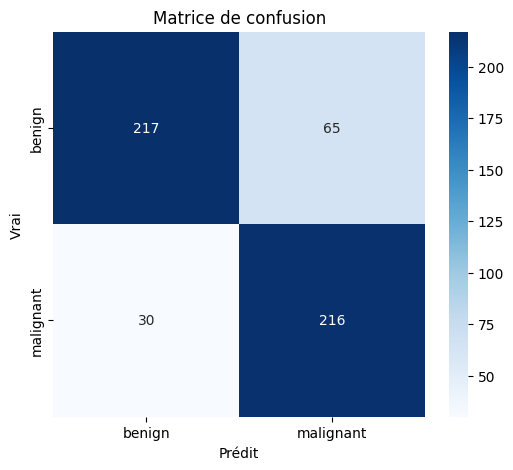


 √âpoque 8/10


Perte d'entra√Ænement : 0.3393

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.90      0.73      0.81       282
   malignant       0.75      0.91      0.82       246

    accuracy                           0.81       528
   macro avg       0.82      0.82      0.81       528
weighted avg       0.83      0.81      0.81       528



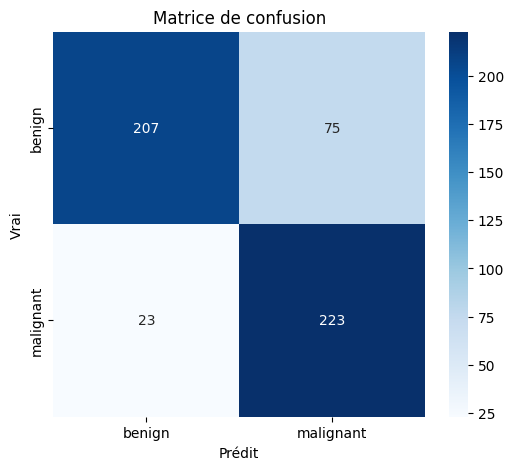


 √âpoque 9/10


Perte d'entra√Ænement : 0.3354

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.89      0.75      0.81       282
   malignant       0.76      0.90      0.82       246

    accuracy                           0.82       528
   macro avg       0.83      0.82      0.82       528
weighted avg       0.83      0.82      0.82       528



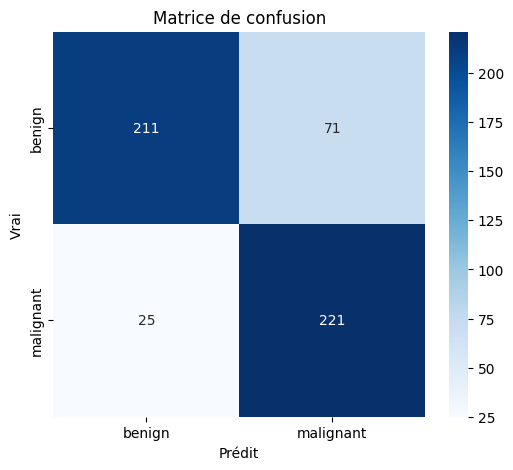


 √âpoque 10/10


Perte d'entra√Ænement : 0.3353

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.85      0.79      0.82       282
   malignant       0.78      0.84      0.81       246

    accuracy                           0.82       528
   macro avg       0.82      0.82      0.82       528
weighted avg       0.82      0.82      0.82       528



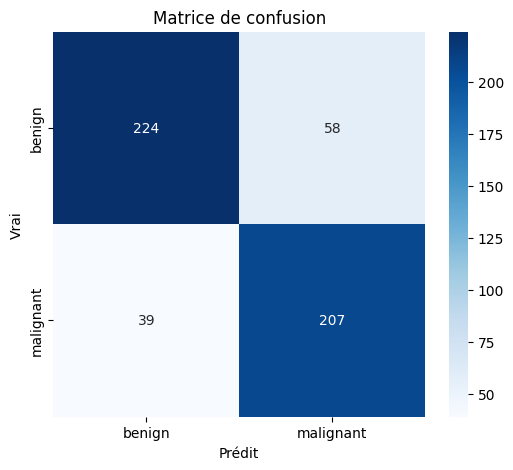

In [109]:
# Entra√Ænement du mod√®le
train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10)

### Pourquoi ces m√©triques ?
En contexte m√©dical, il ne suffit pas d'avoir une bonne "accuracy".
On doit surtout analyser :
- la "sensibilit√©" (Recall) ‚Üí √©viter les faux n√©gatifs (ne pas rater une maladie)
- la "sp√©cificit√©" ‚Üí √©viter les faux positifs (ne pas alarmer √† tort)
- la "valeur pr√©dictive positive" (PPV)
- le "F1-score" qui √©quilibre pr√©cision et rappel

## √âtape 5 : Gestion du d√©s√©quilibre avec une perte pond√©r√©e (Weighted Loss)

Objectif :Lorsque les classes sont d√©s√©quilibr√©es (ex: 90% classe 0, 10% classe 1), le mod√®le aura tendance √† ignorer la classe minoritaire. Pour corriger cela, on pond√®re la fonction de perte selon la fr√©quence des classes.

### 5.1 Calcul des poids inverses en fonction de la fr√©quence des classes

In [122]:
from collections import Counter
import torch

# Supposons que vous avez une liste de labels
labels_list = [label for _, label in train_dataset]  # train_dataset est un Dataset PyTorch
class_counts = Counter(labels_list)

# Nombre total d'√©chantillons
total_samples = sum(class_counts.values())

# Calcul du poids inversement proportionnel √† la fr√©quence
class_weights = {cls: total_samples/count for cls, count in class_counts.items()}

# Conversion en tensor (attention √† l'ordre des classes !)
weights = torch.tensor([class_weights[i] for i in range(len(class_counts))], dtype=torch.float).to(device)


### 5.2 Utilisation avec nn.CrossEntropyLoss

In [124]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss(weight=weights)


### Exemple complet int√©gr√© dans l'entra√Ænement :


 √âpoque 1/10


Perte d'entra√Ænement : 0.3229

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.90      0.83      0.87       296
   malignant       0.81      0.88      0.84       232

    accuracy                           0.86       528
   macro avg       0.85      0.86      0.86       528
weighted avg       0.86      0.86      0.86       528



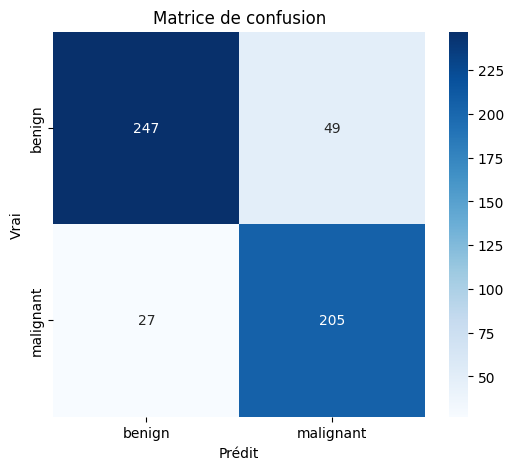


 √âpoque 2/10


Perte d'entra√Ænement : 0.3023

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.95      0.77      0.85       296
   malignant       0.76      0.95      0.84       232

    accuracy                           0.85       528
   macro avg       0.86      0.86      0.85       528
weighted avg       0.87      0.85      0.85       528



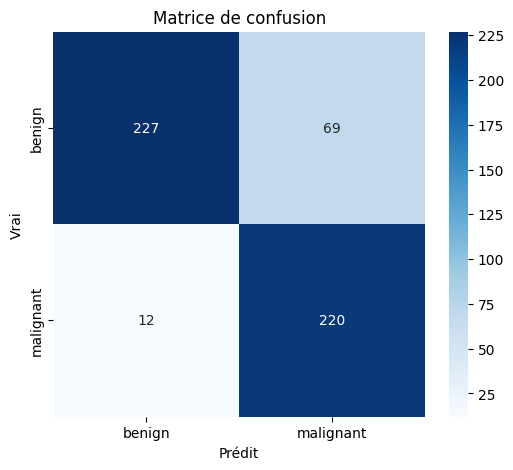


 √âpoque 3/10


Perte d'entra√Ænement : 0.2959

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.95      0.79      0.86       296
   malignant       0.78      0.94      0.85       232

    accuracy                           0.86       528
   macro avg       0.86      0.87      0.86       528
weighted avg       0.87      0.86      0.86       528



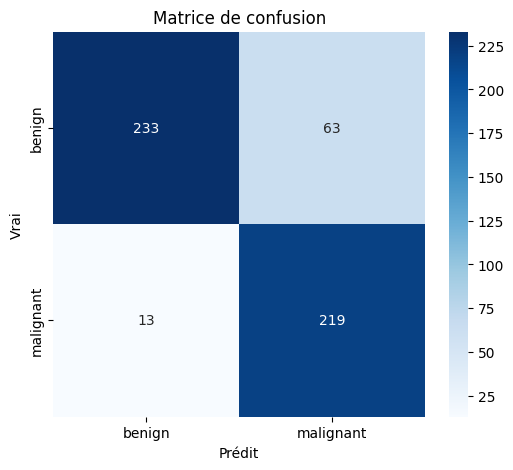


 √âpoque 4/10


Perte d'entra√Ænement : 0.2926

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.94      0.77      0.85       296
   malignant       0.76      0.94      0.84       232

    accuracy                           0.84       528
   macro avg       0.85      0.85      0.84       528
weighted avg       0.86      0.84      0.84       528



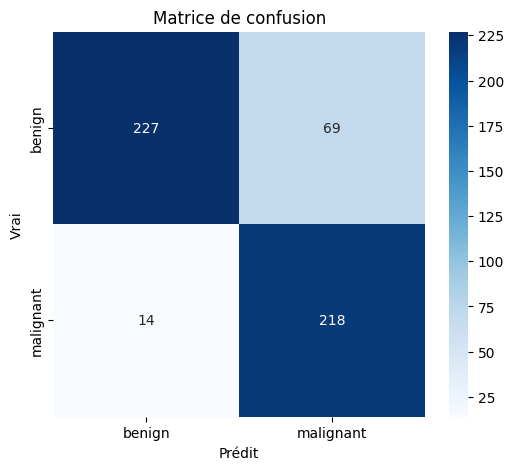


 √âpoque 5/10


Perte d'entra√Ænement : 0.2894

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.92      0.81      0.86       296
   malignant       0.79      0.91      0.85       232

    accuracy                           0.85       528
   macro avg       0.85      0.86      0.85       528
weighted avg       0.86      0.85      0.85       528



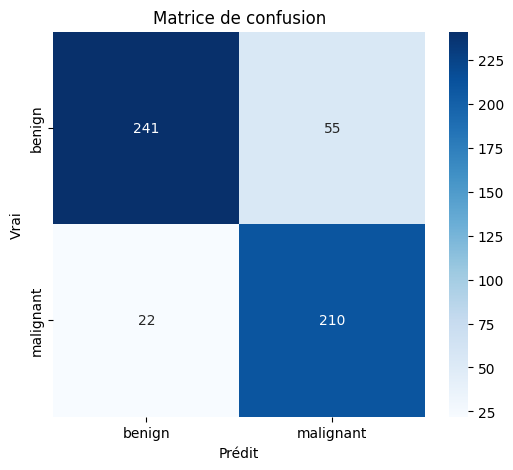


 √âpoque 6/10


Perte d'entra√Ænement : 0.2878

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.94      0.78      0.85       296
   malignant       0.77      0.94      0.85       232

    accuracy                           0.85       528
   macro avg       0.86      0.86      0.85       528
weighted avg       0.87      0.85      0.85       528



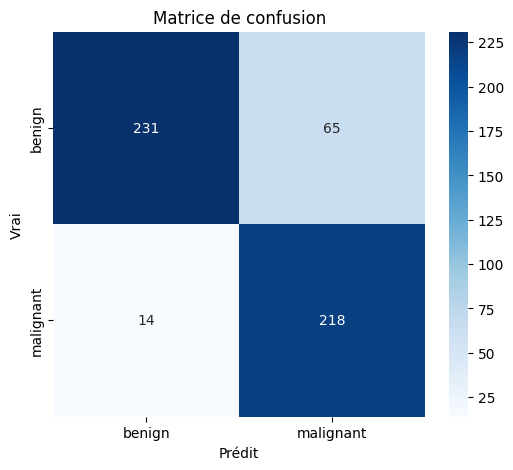


 √âpoque 7/10


Perte d'entra√Ænement : 0.2544

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.95      0.78      0.85       296
   malignant       0.77      0.94      0.85       232

    accuracy                           0.85       528
   macro avg       0.86      0.86      0.85       528
weighted avg       0.87      0.85      0.85       528



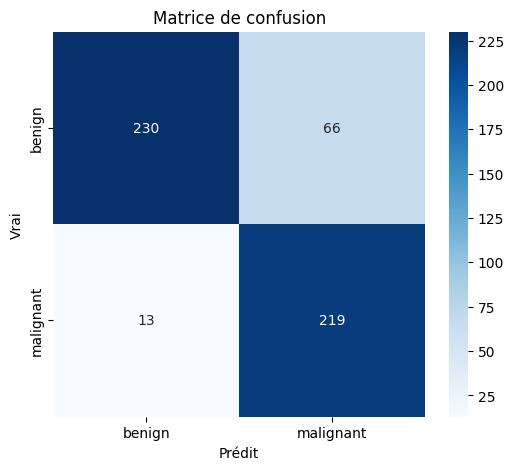


 √âpoque 8/10


Perte d'entra√Ænement : 0.2569

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.89      0.79      0.84       296
   malignant       0.77      0.88      0.82       232

    accuracy                           0.83       528
   macro avg       0.83      0.83      0.83       528
weighted avg       0.84      0.83      0.83       528



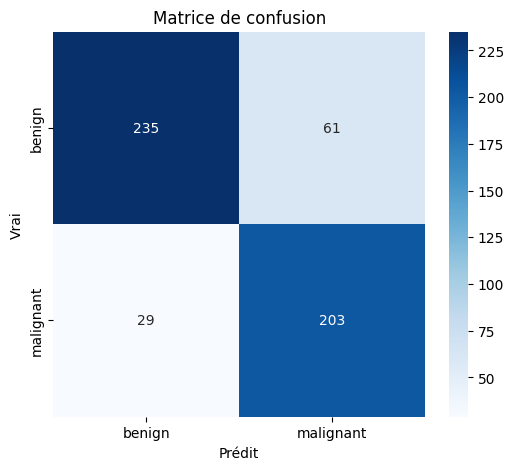


 √âpoque 9/10


Perte d'entra√Ænement : 0.2389

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.85      0.88      0.86       296
   malignant       0.84      0.80      0.82       232

    accuracy                           0.84       528
   macro avg       0.84      0.84      0.84       528
weighted avg       0.84      0.84      0.84       528



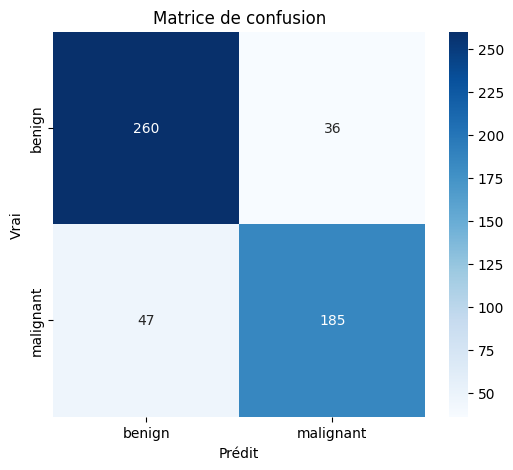


 √âpoque 10/10


Perte d'entra√Ænement : 0.2348

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.96      0.79      0.87       296
   malignant       0.78      0.96      0.86       232

    accuracy                           0.87       528
   macro avg       0.87      0.88      0.87       528
weighted avg       0.88      0.87      0.87       528



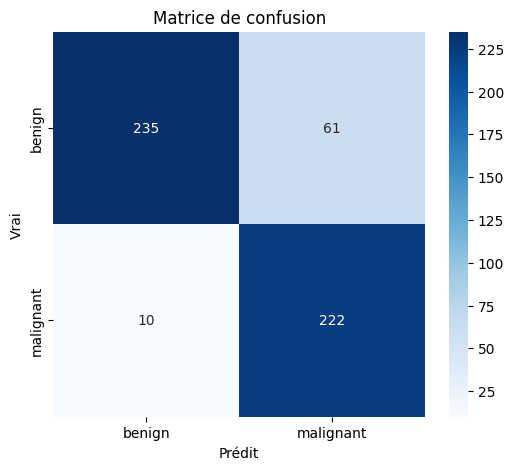

In [126]:
# Calcul des poids une seule fois
from collections import Counter

labels_list = [label for _, label in train_dataset]
class_counts = Counter(labels_list)
total_samples = sum(class_counts.values())
weights = torch.tensor(
    [total_samples / class_counts[i] for i in range(len(class_counts))],
    dtype=torch.float
).to(device)

# Nouvelle fonction de perte pond√©r√©e
criterion = nn.CrossEntropyLoss(weight=weights)

# Entra√Ænement comme avant
train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10)


### V√©rification facultative :
- Tu peux imprimer weights pour v√©rifier que la classe minoritaire a un poids plus grand.
- Tu peux aussi afficher une matrice de confusion apr√®s entra√Ænement pour valider que les classes rares sont mieux d√©tect√©es.

## √âtape 6 : Sauvegarde et Chargement du Mod√®le

### 6.1 Sauvegarder le mod√®le

In [132]:
# üìå Sauvegarde du mod√®le entra√Æn√©
model_path = "mon_model_cnn.pth"
torch.save(model.state_dict(), model_path)

print(f"Mod√®le sauvegard√© dans : {model_path}")


Mod√®le sauvegard√© dans : mon_model_cnn.pth


### 6.2 Recharger le mod√®le ult√©rieurement


In [134]:
# üîÅ Red√©finir l'architecture (m√™me structure que celle utilis√©e lors de l'entra√Ænement)
model = CustomCNN(num_classes=num_classes)
model.load_state_dict(torch.load("mon_model_cnn.pth"))
model.eval()  # mode √©valuation

print("Mod√®le charg√© avec succ√®s.")


Mod√®le charg√© avec succ√®s.


## √âtape 7 : Inf√©rence sur de nouvelles images

### 7.1 Fonction d'inf√©rence sur une image unique

In [160]:
from PIL import Image
import torchvision.transforms as transforms
import torch

def pr√©dire_image(image_path, model, device, class_names):
    """
    Fonction pour charger une image, l'appliquer les m√™mes transformations,
    la passer au mod√®le et afficher la pr√©diction.
    """
    # Transforms identiques √† celles du DataLoader
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # Chargement de l'image  
    image = Image.open(image_path).convert("RGB")  
    image_tensor = transform(image).unsqueeze(0).to(device)  
    
    # Mode √©valuation  
    model.eval()  
    with torch.no_grad():  
        outputs = model(image_tensor)  
        _, predicted = torch.max(outputs, 1)  
    
    classe_pr√©vue = class_names[predicted.item()]  
    print(f"Classe pr√©dite : {classe_pr√©vue}")  
    return classe_pr√©vue  

### 7.2 Utilisation de la fonction

In [162]:
image_path = "D:/image_test.jpg"
class_names = train_dataset.classes
pr√©dire_image(image_path, model, device, class_names)

Classe pr√©dite : malignant


'malignant'

## √âtape 8 : √âvaluation compl√®te du mod√®le

#### M√©triques √† calculer :
1. Accuracy (Pr√©cision globale)
2. Pr√©cision (Precision)
3. Rappel (Recall / Sensibilit√©)
4. Sp√©cificit√©
5. Score F1
6. Matrice de confusion
7. Valeur pr√©dictive positive et n√©gative
8. Courbe ROC + AUC

### 8.1 R√©cup√©ration des pr√©dictions et labels

In [164]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def √©valuer_model(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)


### 8.2 Rapport de classification & matrice de confusion

Rapport de classification :
              precision    recall  f1-score   support

      benign       0.95      0.78      0.86       296
   malignant       0.77      0.94      0.85       232

    accuracy                           0.85       528
   macro avg       0.86      0.86      0.85       528
weighted avg       0.87      0.85      0.85       528



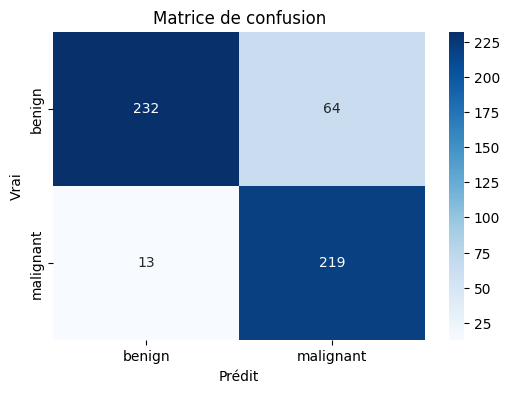

In [166]:
preds, labels, probs = √©valuer_model(model, val_loader, device, class_names)

# Classification Report
print("Rapport de classification :")
print(classification_report(labels, preds, target_names=class_names))

# Matrice de confusion
plt.figure(figsize=(6, 4))
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Pr√©dit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion")
plt.show()


### 8.3 M√©triques suppl√©mentaires (sp√©cificit√©, VPP, VPN‚Ä¶)

In [168]:
# Calcul manuel de la sp√©cificit√©, VPP et VPN (pour binaire uniquement)
if len(class_names) == 2:
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    sensibilit√© = tp / (tp + fn)
    sp√©cificit√© = tn / (tn + fp)
    vpp = tp / (tp + fp)
    vpn = tn / (tn + fn)
    
    print(f"Sensibilit√© : {sensibilit√©:.2f}")
    print(f"Sp√©cificit√© : {sp√©cificit√©:.2f}")
    print(f"Valeur Pr√©dictive Positive (VPP) : {vpp:.2f}")
    print(f"Valeur Pr√©dictive N√©gative (VPN) : {vpn:.2f}")


Sensibilit√© : 0.94
Sp√©cificit√© : 0.78
Valeur Pr√©dictive Positive (VPP) : 0.77
Valeur Pr√©dictive N√©gative (VPN) : 0.95


### 8.4 Courbe ROC et AUC

(binaire uniquement)

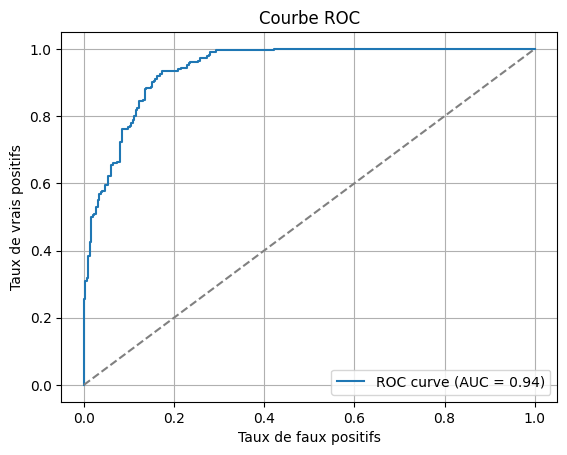

In [205]:
if len(class_names) == 2:
    fpr, tpr, _ = roc_curve(labels, probs[:, 1])
    auc = roc_auc_score(labels, probs[:, 1])

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
    plt.title("Courbe ROC")
    plt.legend()
    plt.grid(True)
    plt.show()